# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

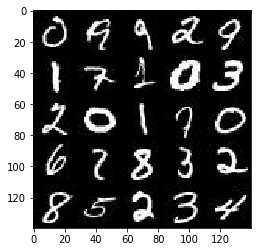

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

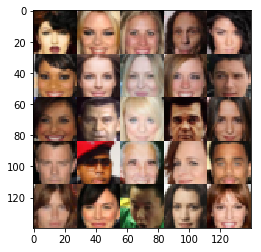

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img_dim = (image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, shape=(None, *img_dim), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    def get_loss(logits, zero_like=True, smooth=0.9):
        if zero_like:
            labels = tf.zeros_like(logits) * smooth
        else:
            labels = tf.ones_like(logits) * smooth
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)  
        return tf.reduce_mean(cross_entropy)

    d_loss_real = get_loss(d_logits_real, zero_like=False)
    d_loss_fake = get_loss(d_logits_fake, zero_like=True)
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = get_loss(d_logits_fake, zero_like=False)

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode, save_as=None, show_face_n=36):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = data_shape[3]
    losses = []
    steps, print_every, show_every = 0, 20, 100
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim) 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    # Only save generator variables
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)
  
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, show_face_n, input_z, out_channel_dim, data_image_mode)
        
        if save_as is not None:
            saver.save(sess, 'checkpoints/{0}.ckpt'.format(save_as))
    
    try:
        # Plot Loss
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
        plt.plot(losses.T[1], label='Generator', alpha=0.5)
        plt.title("Training Losses")
        plt.legend()
    except Exception as e:
        pass         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1283... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 2.1268... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.9771... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 1.6980... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.5507


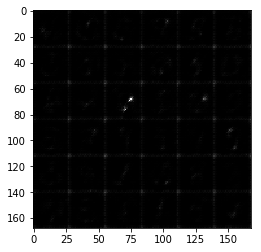

Epoch 1/2... Discriminator Loss: 1.6398... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.5405


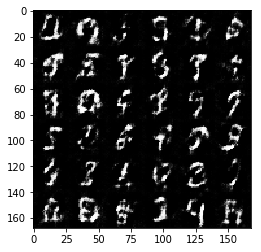

Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.5332


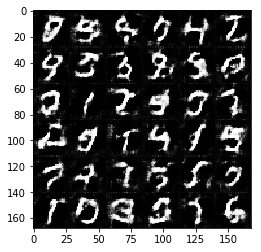

Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.6937


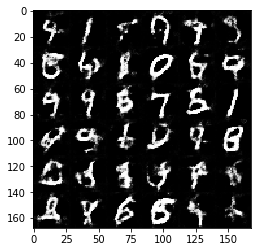

Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.6396


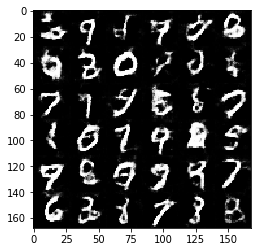

Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.7246


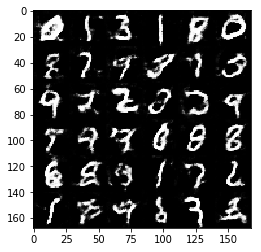

Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.7707


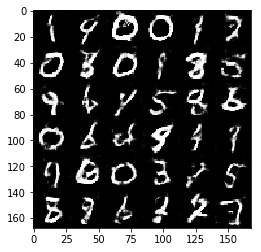

Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8191


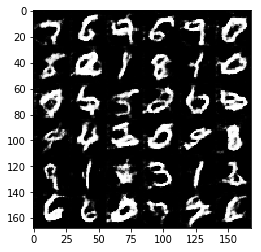

Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.4654
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.4557
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.4971


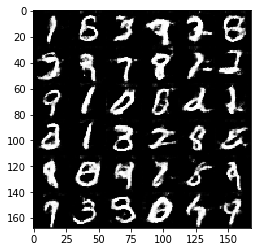

Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.5398... Generator Loss: 0.5218


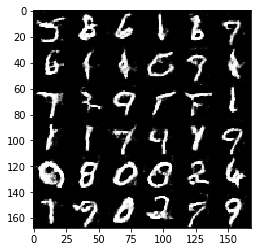

Epoch 2/2... Discriminator Loss: 1.6109... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.6811... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.5755


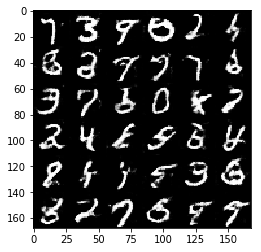

Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.5496... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.8652


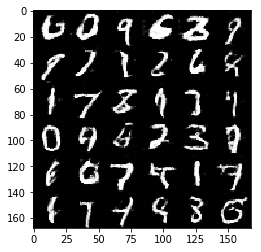

Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 1.1045


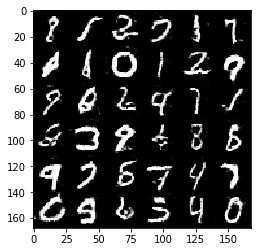

Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.5855
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 1.5085... Generator Loss: 0.5686


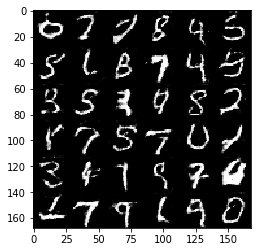

Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.8611


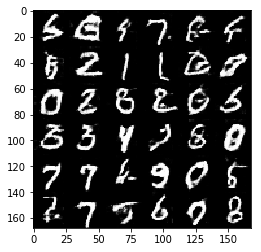

Epoch 2/2... Discriminator Loss: 1.6543... Generator Loss: 0.4485
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7111


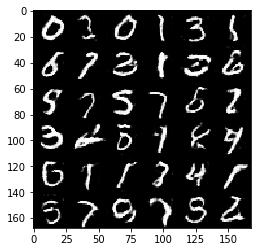

Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.7369


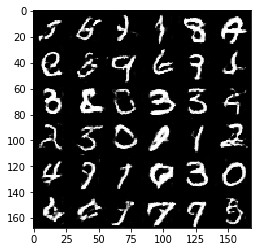

Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.5087... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.5756


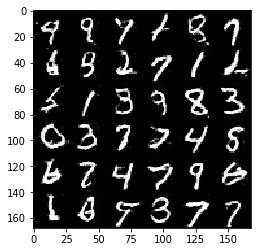

Epoch 2/2... Discriminator Loss: 1.4938... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6391


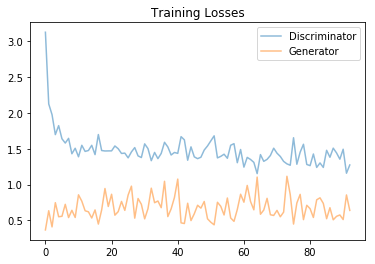

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_as='mnist_generator')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9032... Generator Loss: 0.0950
Epoch 1/1... Discriminator Loss: 2.2838... Generator Loss: 0.2795
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 0.2881
Epoch 1/1... Discriminator Loss: 2.3578... Generator Loss: 0.2836


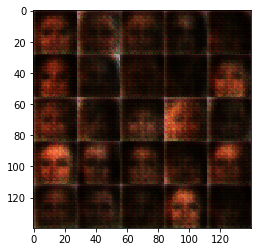

Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.8763... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.4684


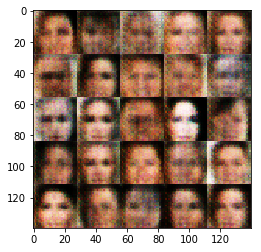

Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.4386
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.8713... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.4543


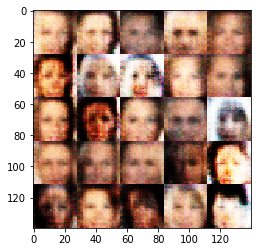

Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.5816


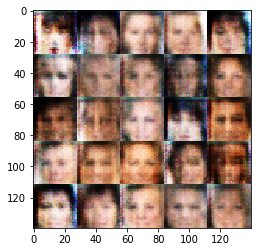

Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6201


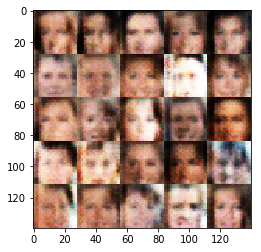

Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6509


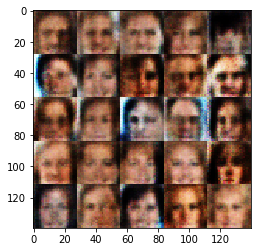

Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6385


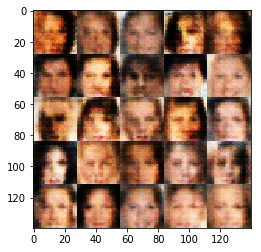

Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7266


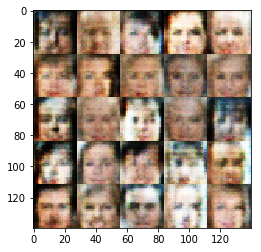

Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5732


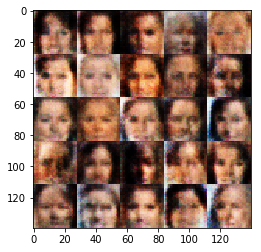

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7037


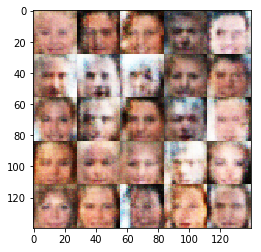

Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6602


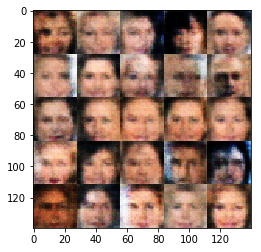

Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6817


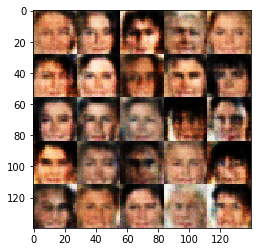

Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5756


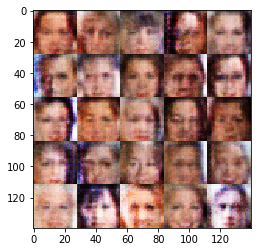

Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6849


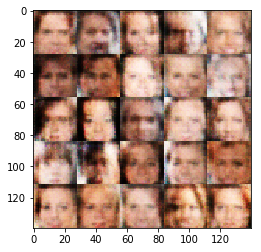

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6135


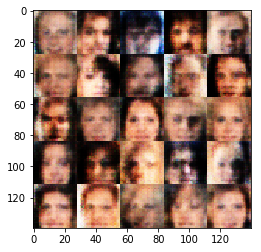

Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6459


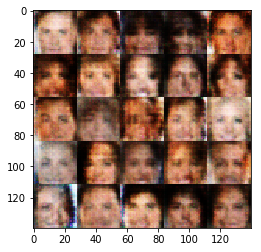

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6654


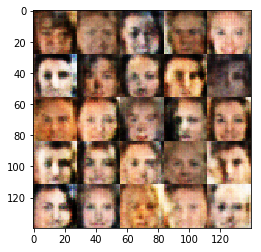

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6071


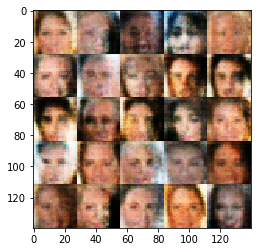

Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6752


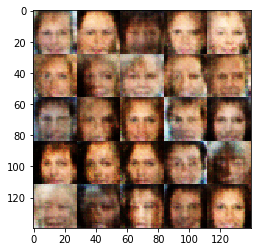

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6059


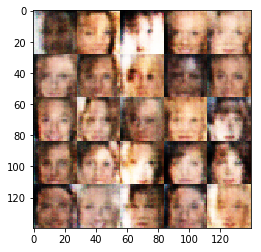

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6513


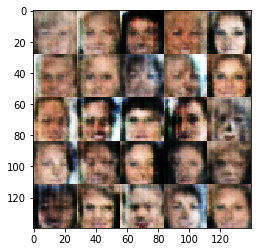

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6299


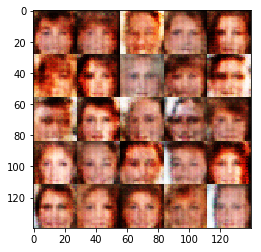

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.6514


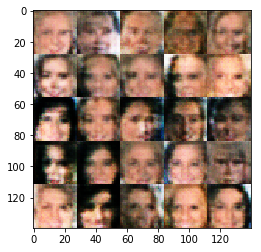

Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6951


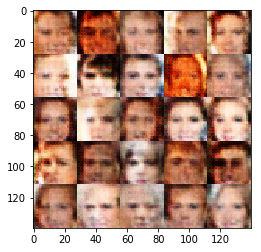

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6698


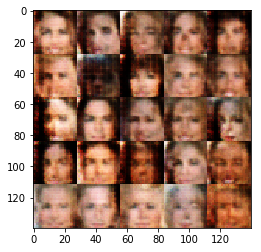

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6764


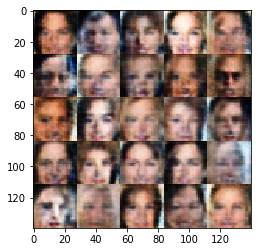

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6793


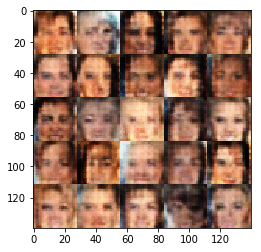

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6664


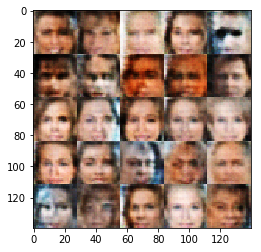

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6657


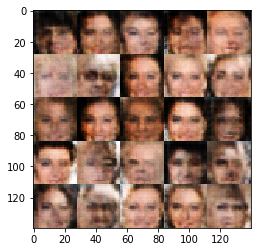

Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6566


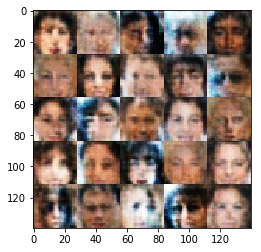

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6495


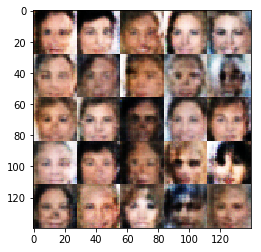

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6507


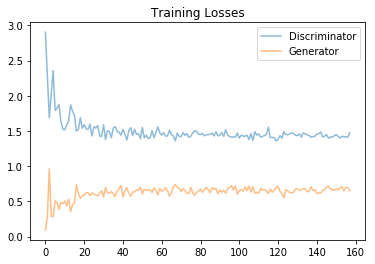

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, save_as='celeba_generator')

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.